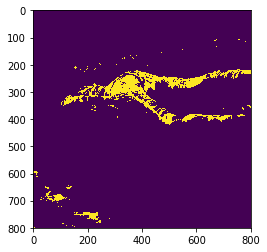

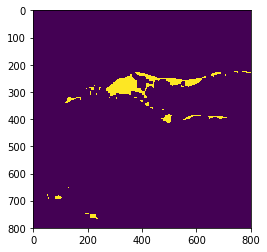

'\n%matplotlib inline\ndip.imshow(threshMap)\ndip.show()\n'

In [1]:
import cv2
import numpy as np
import dippykit as dip
import matplotlib.pyplot as plt
import pandas as pd


#PICKING AN IMAGE
im_original = cv2.imread("images/UW_400.png")
#im_original = cv2.imread("images/underwater-15.png")

#im_original = cv2.imread("images/24Zimmer-Refer-articleLarge.jpg")

#INITIAL EXPLORATION OF THE PICTURE

#Select pixels that are similar in color to skin
im_skin = np.copy(im_original)
for i in range(np.shape(im_original)[0]):
    for j in range(np.shape(im_original)[1]):
        #if im_original[i,j][2] < 60:
        if im_original[i,j][2] < 60 or im_original[i,j][0] > 200: #Zones mostly reddish, not blueish
            im_skin[i,j]=[0,0,0]

cv2.imwrite("temp_images/tree_morf/skin_color.png", im_skin)

#Select zones with high luminosity (probably zones iluminated by refracted light)
im_gray = cv2.cvtColor(im_original, cv2.COLOR_BGR2GRAY)
ret,th1 = cv2.threshold(im_gray,180,255,cv2.THRESH_BINARY)

kernel = np.ones((5,5),np.uint8)
binary_morf = cv2.morphologyEx(th1, cv2.MORPH_CLOSE, kernel)
#binary_morf = cv2.dilate(th1,kernel,iterations = 1)
#binary_morf = cv2.dilate(th1,kernel,iterations = 2)
binary_morf = cv2.erode(binary_morf,kernel,iterations = 2)
cv2.imwrite("temp_images/tree_morf/binary_morf.png", binary_morf )

"""
#Saliency detection
# initialize OpenCV's static fine grained saliency detector and compute the saliency map
saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap) = saliency.computeSaliency(im_original)

# if we would like a *binary* map that we could process for contours,
# compute convex hull's, extract bounding boxes, etc., we can
# additionally threshold the saliency map

threshMap = cv2.threshold(saliencyMap*255, 80, 255,cv2.THRESH_BINARY)[1]

cv2.imwrite("temp_images/saliency.png", saliencyMap*255)
"""

%matplotlib inline
dip.imshow(th1)
dip.show()

%matplotlib inline
dip.imshow(binary_morf)
dip.show()

"""
%matplotlib inline
dip.imshow(threshMap)
dip.show()
"""

In [2]:
"""
def reduce_mask(mask):

    N,M = np.shape(mask)
    WHITE = 255
    DARKEN_LAYER = 0

    for i in range(N):

        edge_detected = False
        for j in range(M):

            if mask[i][j] == WHITE and edge_detected == False:
                mask[i][j] = 0
                if j+DARKEN_LAYER<M:
                    for k in range(1,DARKEN_LAYER+1):
                        mask[i][j+k]=0

                if j+DARKEN_LAYER+1 == WHITE:
                    edge_detected = True

            elif mask[i][j] == 0 and edge_detected == True:
                mask[i][j-1] = 0
                edge_detected = False
                if j-DARKEN_LAYER>=0:
                    for k in range(1,DARKEN_LAYER+1):
                        mask[i][j-k]=0
                        
"""

'\ndef reduce_mask(mask):\n\n    N,M = np.shape(mask)\n    WHITE = 255\n    DARKEN_LAYER = 0\n\n    for i in range(N):\n\n        edge_detected = False\n        for j in range(M):\n\n            if mask[i][j] == WHITE and edge_detected == False:\n                mask[i][j] = 0\n                if j+DARKEN_LAYER<M:\n                    for k in range(1,DARKEN_LAYER+1):\n                        mask[i][j+k]=0\n\n                if j+DARKEN_LAYER+1 == WHITE:\n                    edge_detected = True\n\n            elif mask[i][j] == 0 and edge_detected == True:\n                mask[i][j-1] = 0\n                edge_detected = False\n                if j-DARKEN_LAYER>=0:\n                    for k in range(1,DARKEN_LAYER+1):\n                        mask[i][j-k]=0\n                        \n'

In [3]:
#binary_morf

In [4]:
class Pixel(object):
    def __init__(self):
        self.position = None
        self.neighbors = None

In [5]:
#Interpolation without morfological operations

im_skin_interp = np.copy(im_skin)

#Step 1: Go over all the pixels of "Zones similar to skin color" using a square of 4 pixels

for i in range(np.shape(im_skin)[0] - 1):
    for j in range(np.shape(im_skin)[1] -1):
        
        pixel_upper_left = im_skin[i,j]
        pixel_upper_rigth = im_skin[i,j+1]
        pixel_bottom_left = im_skin[i+1 ,j]
        pixel_bottom_rigth = im_skin[i+1,j+1]
        
        pixel_array = [pixel_upper_left, pixel_upper_rigth, pixel_bottom_left, pixel_bottom_rigth]
        
        remove_pixel = [False, False, False, False]
        
                
        #Step 2: Check if at least one of the 4 pixels correspond to the body (i.e. it isn´t black)
        
        if (pixel_upper_left > ([0, 0, 0])).all() or (pixel_upper_rigth > ([0,0,0])).all or (pixel_bottom_left > ([0,0,0])).all() or (pixel_bottom_rigth > ([0,0,0])).all():
            
            #Step 3: Check if any of those pixels are marked as pixels to remove (i.e. they are white on image after binary threshold)
            if th1[i,j] == 255: 
                remove_pixel[0] = True
            if th1[i,j+1] == 255: 
                remove_pixel[1] = True
            if th1[i+1,j] == 255: 
                remove_pixel[2] = True
            if th1[i+1,j+1] == 255: 
                remove_pixel[3] = True
            
            #We need to remove the targeted pixels and substitute its value with the average of the surrounding pixels that are part of the body
            
            aux_pixel_value = [0,0,0]
            num_pixels_for_average = 0
            
            for p in range(np.shape(pixel_array)[0]):
                #if remove_pixel[p] == False and (pixel_array[p] > ([0, 0, 0])).all(): 
                if remove_pixel[p] == False: #Using this condition, the image has less false skin-coloured pixels
                    aux_pixel_value = aux_pixel_value + pixel_array[p]
                    num_pixels_for_average = num_pixels_for_average + 1
                    
            if num_pixels_for_average > 0: 
                avg_pixel_value = aux_pixel_value/num_pixels_for_average
            elif num_pixels_for_average == 0:
                avg_pixel_value = (255,0,0)
                
            
            for p in range(np.shape(pixel_array)[0]):
                if remove_pixel[p] == True: 
                    pixel_array[p] =  avg_pixel_value
                   
            if (im_skin[i,j] == [0,0,0]).all():
                im_skin_interp[i,j] = pixel_array[0]
            if (im_skin[i,j+1] == [0,0,0]).all():
                im_skin_interp[i,j+1] = pixel_array[1]
            if (im_skin[i+1,j] == [0,0,0]).all():
                im_skin_interp[i+1 ,j] = pixel_array[2]
            if (im_skin[i+1,j+1] == [0,0,0]).all():
                im_skin_interp[i+1,j+1] = pixel_array[3]
            """
            
            im_skin_interp[i,j] = pixel_array[0]
            im_skin_interp[i,j+1] = pixel_array[1]
            im_skin_interp[i+1,j] = pixel_array[2]
            im_skin_interp[i+1,j+1] = pixel_array[3]
            
            """ 
            
cv2.imwrite("temp_images/tree_morf/skin_color_interpolated.png", im_skin_interp)           
            


True

In [6]:
#Interpolation with morfological operations

im_skin_interp_morf = np.copy(im_skin)

#Step 1: Go over all the pixels of "Zones similar to skin color" using a square of 4 pixels

for i in range(np.shape(im_skin)[0] - 1):
    for j in range(np.shape(im_skin)[1] -1):
        
        pixel_upper_left = im_skin[i,j]
        pixel_upper_rigth = im_skin[i,j+1]
        pixel_bottom_left = im_skin[i+1 ,j]
        pixel_bottom_rigth = im_skin[i+1,j+1]
        
        pixel_array = [pixel_upper_left, pixel_upper_rigth, pixel_bottom_left, pixel_bottom_rigth]
        
        remove_pixel = [False, False, False, False]
        
                
        #Step 2: Check if at least one of the 4 pixels correspond to the body (i.e. it isn´t black)
        
        if (pixel_upper_left > ([0, 0, 0])).all() or (pixel_upper_rigth > ([0,0,0])).all or (pixel_bottom_left > ([0,0,0])).all() or (pixel_bottom_rigth > ([0,0,0])).all():
            
            #Step 3: Check if any of those pixels are marked as pixels to remove (i.e. they are white on image after binary threshold)
            if binary_morf[i,j] == 255: 
                remove_pixel[0] = True
            if binary_morf[i,j+1] == 255: 
                remove_pixel[1] = True
            if binary_morf[i+1,j] == 255: 
                remove_pixel[2] = True
            if binary_morf[i+1,j+1] == 255: 
                remove_pixel[3] = True
            
            #We need to remove the targeted pixels and substitute its value with the average of the surrounding pixels that are part of the body
            
            aux_pixel_value = [0,0,0]
            num_pixels_for_average = 0
            
            for p in range(np.shape(pixel_array)[0]):
                #if remove_pixel[p] == False and (pixel_array[p] > ([0, 0, 0])).all(): 
                if remove_pixel[p] == False: #Using this condition, the image has less false skin-coloured pixels
                    aux_pixel_value = aux_pixel_value + pixel_array[p]
                    num_pixels_for_average = num_pixels_for_average + 1
                    
            if num_pixels_for_average > 0: 
                avg_pixel_value = aux_pixel_value/num_pixels_for_average
            elif num_pixels_for_average == 0:
                avg_pixel_value = (255,0,0)
                
            
            for p in range(np.shape(pixel_array)[0]):
                if remove_pixel[p] == True: 
                    pixel_array[p] =  avg_pixel_value
            """        
            if (im_skin[i,j] == [0,0,0]).all():
                im_skin_interp[i,j] = pixel_array[0]
            if (im_skin[i,j+1] == [0,0,0]).all():
                im_skin_interp[i,j+1] = pixel_array[1]
            if (im_skin[i+1,j] == [0,0,0]).all():
                im_skin_interp[i+1 ,j] = pixel_array[2]
            if (im_skin[i+1,j+1] == [0,0,0]).all():
                im_skin_interp[i+1,j+1] = pixel_array[3]
            """
            
            im_skin_interp_morf[i,j] = pixel_array[0]
            im_skin_interp_morf[i,j+1] = pixel_array[1]
            im_skin_interp_morf[i+1,j] = pixel_array[2]
            im_skin_interp_morf[i+1,j+1] = pixel_array[3]
            
            
cv2.imwrite("temp_images/tree_morf/skin_color_interpolated_morf.png", im_skin_interp_morf)           
            


True

In [7]:
"""

im_skin_interp_def = np.copy(im_original)
block_size = 40
for i in range(0, int(np.shape(im_original)[0]/block_size)):
    for j in range(0, int(np.shape(im_original)[1]/block_size)):
        
        block_interp = im_skin_interp[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
        block_interp_morf = im_skin_interp_morf[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
        
        num_color_pixels = 0
        num_color_pixels_morf = 0
        
        for item in block_interp:
            if (item > (0,0,0)).all() and  (item != (255,0,0)).all():
                num_color_pixels = num_color_pixels + 1
                
        for item in block_interp_morf:
            if (item > (0,0,0)).all() and  (item != (255,0,0)).all():
                num_color_pixels_morf = num_color_pixels_morf + 1
                
        print(num_color_pixels, num_color_pixels_morf)
        
        if num_color_pixels_morf < 0.8*num_color_pixels: 
            im_skin_interp_def[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = im_skin_interp[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
        else: 
            im_skin_interp_def[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = im_skin_interp_morf[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
        
            
            
cv2.imwrite("temp_images/tree_morf/skin_color_interpolated_def.png", im_skin_interp_def)           
  
"""
       

'\n\nim_skin_interp_def = np.copy(im_original)\nblock_size = 40\nfor i in range(0, int(np.shape(im_original)[0]/block_size)):\n    for j in range(0, int(np.shape(im_original)[1]/block_size)):\n        \n        block_interp = im_skin_interp[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]\n        block_interp_morf = im_skin_interp_morf[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]\n        \n        num_color_pixels = 0\n        num_color_pixels_morf = 0\n        \n        for item in block_interp:\n            if (item > (0,0,0)).all() and  (item != (255,0,0)).all():\n                num_color_pixels = num_color_pixels + 1\n                \n        for item in block_interp_morf:\n            if (item > (0,0,0)).all() and  (item != (255,0,0)).all():\n                num_color_pixels_morf = num_color_pixels_morf + 1\n                \n        print(num_color_pixels, num_color_pixels_morf)\n        \n        if num_color_pixels_morf < 0.8*num_color_pixels: 

In [8]:
im_skin_interp_def = np.copy(im_skin_interp_morf)

block_size = 80
for i in range(0, int(np.shape(im_original)[0]/block_size)):
    for j in range(0, int(np.shape(im_original)[1]/block_size)):
        
        block_interp = im_skin_interp[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
        block_interp_morf = im_skin_interp_morf[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
        #print(np.shape(im_skin_interp_morf))
        #print(block_interp)
        
        #print(i*block_size,(i+1)*block_size)
        num_color_pixels_morf = 0
        
        #num_item = 0
        for k in range(0, block_size):
            for l in range(0, block_size):
            #print(np.shape(block_interp_morf.flatten()))
            #num_item = num_item + 1
            
                if (block_interp_morf[k,l] == (255,0,0)).all():
                    num_color_pixels_morf = num_color_pixels_morf + 1
                    #print(block_interp)
                    #print(num_color_pixels_morf)
                    if num_color_pixels_morf > 25:
                        #print(num_color_pixels_morf)
                        #print(i*block_size, j*block_size)
                        continue
        #print(num_item)
        print(num_color_pixels_morf)
        print(i*block_size, j*block_size)
        if num_color_pixels_morf > 0.25*block_size*block_size: 
            im_skin_interp_def[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = im_skin_interp[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            
cv2.imwrite("temp_images/tree_morf/skin_color_interpolated_def.png", im_skin_interp_def)           
       

0
0 0
0
0 80
0
0 160
0
0 240
0
0 320
0
0 400
0
0 480
0
0 560
0
0 640
0
0 720
0
80 0
0
80 80
0
80 160
0
80 240
0
80 320
0
80 400
0
80 480
0
80 560
0
80 640
0
80 720
0
160 0
0
160 80
0
160 160
0
160 240
249
160 320
152
160 400
0
160 480
0
160 560
244
160 640
196
160 720
0
240 0
7
240 80
201
240 160
2014
240 240
3714
240 320
1291
240 400
1141
240 480
1177
240 560
23
240 640
3
240 720
0
320 0
376
320 80
25
320 160
22
320 240
34
320 320
245
320 400
368
320 480
242
320 560
406
320 640
0
320 720
0
400 0
0
400 80
0
400 160
0
400 240
0
400 320
13
400 400
257
400 480
2
400 560
1
400 640
0
400 720
0
480 0
0
480 80
0
480 160
0
480 240
0
480 320
0
480 400
0
480 480
0
480 560
0
480 640
0
480 720
4
560 0
0
560 80
0
560 160
0
560 240
0
560 320
0
560 400
0
560 480
0
560 560
0
560 640
0
560 720
30
640 0
244
640 80
0
640 160
0
640 240
0
640 320
0
640 400
0
640 480
0
640 560
0
640 640
0
640 720
0
720 0
0
720 80
354
720 160
0
720 240
0
720 320
0
720 400
0
720 480
0
720 560
0
720 640
0
720 720


True

In [9]:
#Adding red pixels to the list of pixels to fix. The red pixels are those that couldn be interpolated

list_pixels_to_fix = []

    
for i in range(np.shape(im_skin)[0] - 1):
    for j in range(np.shape(im_skin)[1] -1):
        if (im_skin_interp_def[i,j] == ([255,0,0])).all():
           
            list_pixels_to_fix.append((i,j))

print(list_pixels_to_fix)


[(223, 745), (223, 746), (223, 747), (223, 748), (223, 749), (223, 750), (223, 751), (223, 752), (223, 753), (223, 754), (223, 755), (223, 756), (223, 757), (223, 758), (223, 759), (223, 760), (223, 761), (223, 762), (223, 763), (223, 764), (223, 765), (223, 766), (223, 767), (223, 768), (224, 736), (224, 737), (224, 738), (224, 739), (224, 740), (224, 741), (224, 742), (224, 743), (224, 744), (224, 745), (224, 746), (224, 747), (224, 748), (224, 749), (224, 750), (224, 751), (224, 766), (224, 767), (224, 768), (224, 769), (224, 770), (224, 771), (224, 772), (224, 773), (225, 736), (225, 737), (225, 738), (225, 739), (225, 740), (225, 741), (225, 742), (225, 743), (225, 744), (225, 745), (225, 746), (225, 747), (225, 748), (225, 749), (225, 750), (225, 751), (225, 766), (225, 767), (225, 768), (225, 769), (225, 770), (225, 771), (225, 772), (225, 773), (225, 774), (225, 775), (225, 776), (225, 777), (225, 778), (225, 779), (225, 780), (225, 781), (225, 782), (225, 783), (226, 375), (22

In [10]:
#This block is to find the first order pixels in the first iteration

"""

num_pixel = 0

list_pixels_first_order = []

for item in list_pixels_to_fix: 
        
        # i and j are the coordinates of each red pixel
        i = item[0]
        j = item[1]
        
        initialization_pixel = 0 #That means that the pixel has not been added yet to the list of first order pixels
        
        for row in range(i-1, i+2):
            for col in range(j-1, j+2): 
                #Here it checks if some of the surrounding pixels are not equal to red (i.e. has skin color)
                if (im_skin_interp[row,col] != ([255,0,0])).all():
                    
                    if initialization_pixel == 0: 
                        #the first time, it is created a structure inside the list and the position is registered 
                        #the list of neighbors is initialized
                        list_pixels_first_order.append(num_pixel)
                        list_pixels_first_order[num_pixel] = Pixel()
                        list_pixels_first_order[num_pixel].position = (i,j)
                        list_pixels_first_order[num_pixel].neighbors = []
                        
                        initialization_pixel = 1
                        num_pixel = num_pixel + 1
                    
                    list_pixels_first_order[num_pixel-1].neighbors.append((row,col))
        
        initialization_pixel = 0       
                    
print(list_pixels_first_order[0].position)
print(list_pixels_first_order[0].neighbors)

"""

'\n\nnum_pixel = 0\n\nlist_pixels_first_order = []\n\nfor item in list_pixels_to_fix: \n        \n        # i and j are the coordinates of each red pixel\n        i = item[0]\n        j = item[1]\n        \n        initialization_pixel = 0 #That means that the pixel has not been added yet to the list of first order pixels\n        \n        for row in range(i-1, i+2):\n            for col in range(j-1, j+2): \n                #Here it checks if some of the surrounding pixels are not equal to red (i.e. has skin color)\n                if (im_skin_interp[row,col] != ([255,0,0])).all():\n                    \n                    if initialization_pixel == 0: \n                        #the first time, it is created a structure inside the list and the position is registered \n                        #the list of neighbors is initialized\n                        list_pixels_first_order.append(num_pixel)\n                        list_pixels_first_order[num_pixel] = Pixel()\n                  

In [11]:
#This block is to paint in green those pixels that are considered as first order pixels on the first iteration

"""
for item in list_pixels_first_order:
    # i and j are the coordinates of each first order pixel
    i = item.position[0]
    j = item.position[1]
    
    im_skin_interp[i,j] = [0, 255, 0]
    
%matplotlib inline
dip.imshow(im_skin_interp)
dip.show()

cv2.imwrite("temp_images/skin_color_interpolated_first_order_morf.png", im_skin_interp)

"""

'\nfor item in list_pixels_first_order:\n    # i and j are the coordinates of each first order pixel\n    i = item.position[0]\n    j = item.position[1]\n    \n    im_skin_interp[i,j] = [0, 255, 0]\n    \n%matplotlib inline\ndip.imshow(im_skin_interp)\ndip.show()\n\ncv2.imwrite("temp_images/skin_color_interpolated_first_order_morf.png", im_skin_interp)\n\n'

In [12]:
#This block paints the first order pixels of the first iteration with the average color of the neighbor pixels

"""

for item in list_pixels_first_order:
    # i and j are the coordinates of each first order pixel
    i = item.position[0]
    j = item.position[1]
    #print(sum(np.array(item.neighbors)))
    
    aux_rgb = (0,0,0)
    
    for neighbor in item.neighbors: 
        row = neighbor[0]
        col = neighbor[1]
        
        aux_rgb = aux_rgb + im_skin_interp[row,col]
    
    im_skin_interp[i,j] = aux_rgb/len(item.neighbors)
    print(aux_rgb)
    print(len(item.neighbors))
    print(im_skin_interp[i,j])
    
%matplotlib inline
dip.imshow(im_skin_interp)
dip.show()

cv2.imwrite("temp_images/skin_color_interpolated_first_order_first_stage.png", im_skin_interp)

"""

'\n\nfor item in list_pixels_first_order:\n    # i and j are the coordinates of each first order pixel\n    i = item.position[0]\n    j = item.position[1]\n    #print(sum(np.array(item.neighbors)))\n    \n    aux_rgb = (0,0,0)\n    \n    for neighbor in item.neighbors: \n        row = neighbor[0]\n        col = neighbor[1]\n        \n        aux_rgb = aux_rgb + im_skin_interp[row,col]\n    \n    im_skin_interp[i,j] = aux_rgb/len(item.neighbors)\n    print(aux_rgb)\n    print(len(item.neighbors))\n    print(im_skin_interp[i,j])\n    \n%matplotlib inline\ndip.imshow(im_skin_interp)\ndip.show()\n\ncv2.imwrite("temp_images/skin_color_interpolated_first_order_first_stage.png", im_skin_interp)\n\n'

Ratio: 0


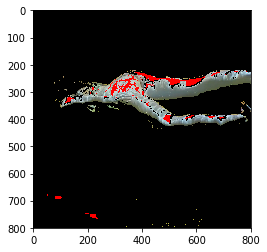

Ratio: 0.7258849740077564


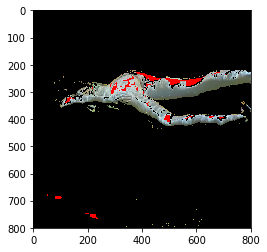

Ratio: 0.5355227328987541


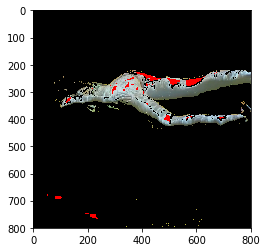

Ratio: 0.40399372885551615


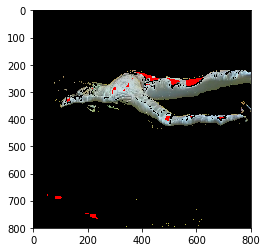

Ratio: 0.3173529169073356


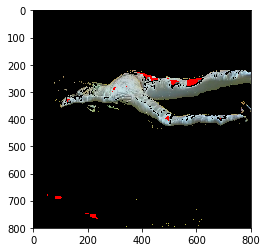

Ratio: 0.25827213466457627


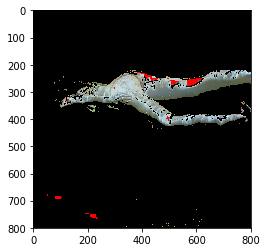

Ratio: 0.2170146051654427


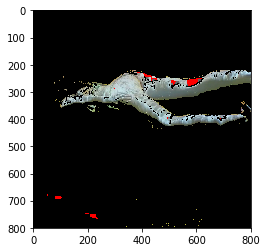

Ratio: 0.18211073520917567


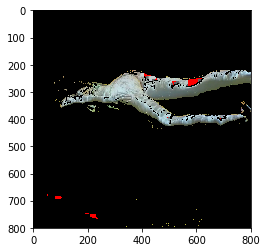

Ratio: 0.1557059163297302


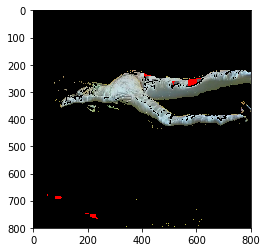

Ratio: 0.13614984734714086


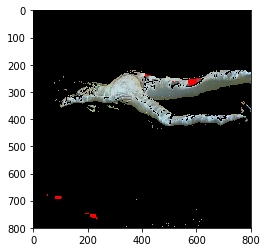

Ratio: 0.12327749814341117


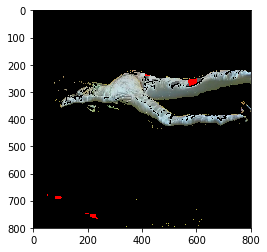

Ratio: 0.11329317600462084


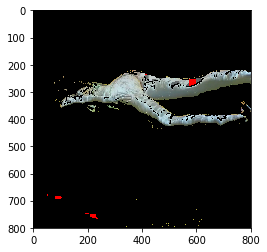

Ratio: 0.10627939598976813


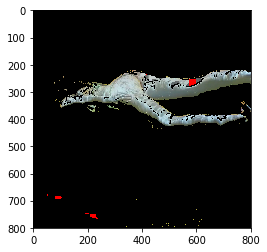

Ratio: 0.10066837197788596


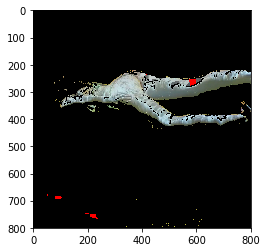

Ratio: 0.0955524383199934


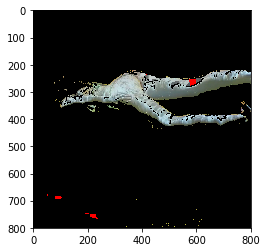

Ratio: 0.09117914019308523


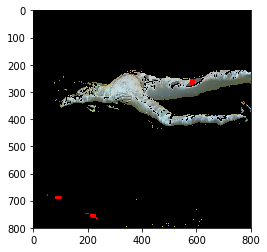

Ratio: 0.08705338724317188


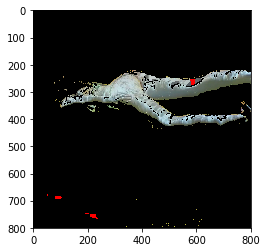

Ratio: 0.0832576945292516


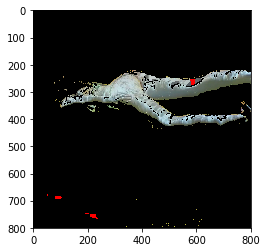

Ratio: 0.07962703193332783


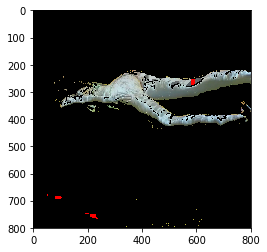

Ratio: 0.07591385427840582


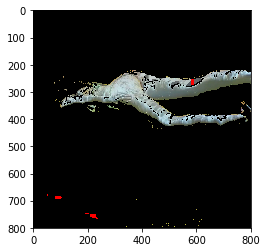

Ratio: 0.07228319168248205


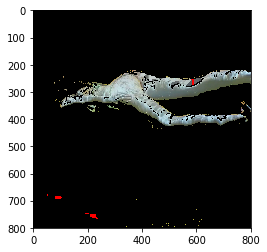

Ratio: 0.06865252908655829


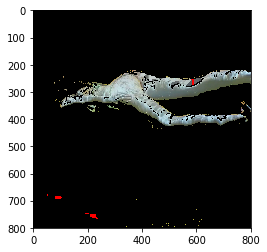

Ratio: 0.06493935143163627


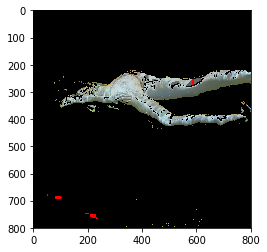

Ratio: 0.06122617377671425


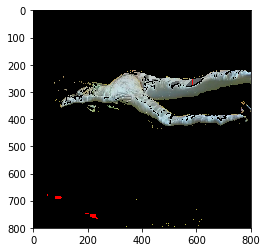

Ratio: 0.057512996121792226


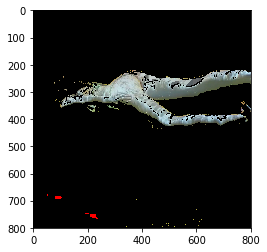

Ratio: 0.05388233352586847


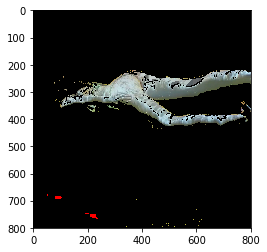

Ratio: 0.05214951728690486


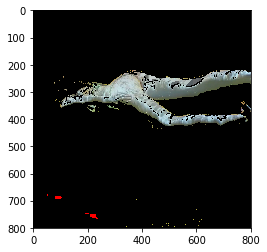

Completed


True

In [13]:
#Iterative method: after selecting the pixels to fix, this block iteratively find the first order pixels 
#in each iteration and paints them averaging the color of the neighbors 


num_total_pix_to_fix = len(list_pixels_to_fix)
num_current_pixels_to_fix = len(list_pixels_to_fix)

#ratio_old = num_current_pixels_to_fix/num_total_pix_to_fix
ratio_new = 0

while True: 
    
    #Step 1: Find which pixels are first order pixels from those we still need to fix
    num_pixel = 0

    list_pixels_first_order = []
    ratio_old = num_current_pixels_to_fix/num_total_pix_to_fix
    
    print("Ratio: " + str(ratio_new))
    
    for item in list_pixels_to_fix: 
        
        # i and j are the coordinates of each red pixel
        i = item[0]
        j = item[1]
        
        initialization_pixel = 0 #That means that the pixel has not been added yet to the list of first order pixels
        
        for row in range(i-1, i+2):
            for col in range(j-1, j+2): 
                #Here it checks if some of the surrounding pixels are not equal to red (i.e. has skin color)
                if (im_skin_interp_def[row,col] != ([255,0,0])).all():
                    
                    if initialization_pixel == 0: 
                        #the first time, it is created a structure inside the list and the position is registered 
                        #the list of neighbors is initialized
                        list_pixels_first_order.append(num_pixel)
                        list_pixels_first_order[num_pixel] = Pixel()
                        list_pixels_first_order[num_pixel].position = (i,j)
                        list_pixels_first_order[num_pixel].neighbors = []
                        
                        initialization_pixel = 1
                        num_pixel = num_pixel + 1
                    
                    list_pixels_first_order[num_pixel-1].neighbors.append((row,col))
        
        initialization_pixel = 0   
        
        
    #Step 2: Interpolate those first order pixels
    
    for item in list_pixels_first_order:
        # i and j are the coordinates of each first order pixel
        i = item.position[0]
        j = item.position[1]
        #print(sum(np.array(item.neighbors)))

        aux_rgb = (0,0,0)

        for neighbor in item.neighbors: 
            row = neighbor[0]
            col = neighbor[1]

            aux_rgb = aux_rgb + im_skin_interp_def[row,col]

        im_skin_interp_def[i,j] = aux_rgb/len(item.neighbors)
        #print(aux_rgb)
        #print(len(item.neighbors))
        #print(im_skin_interp[i,j])
        
        list_pixels_to_fix.remove((i,j))

    num_current_pixels_to_fix = len(list_pixels_to_fix)
    
    ratio_new = num_current_pixels_to_fix/num_total_pix_to_fix
    
    %matplotlib inline
    dip.imshow(im_skin_interp_def)
    dip.show()
    
    #cv2.imwrite("temp_images/tree_morf/skin_color_interpolated_first_order_last_stage_morf.png", im_skin_interp)
    if len(list_pixels_to_fix) == [] or ratio_old == ratio_new:
        print("Completed")
        break
        
"""
%matplotlib inline
dip.imshow(im_skin_interp)
dip.show()
"""   
    
cv2.imwrite("temp_images/tree_morf/skin_color_interpolated_first_order_last_stage.png", im_skin_interp_def)

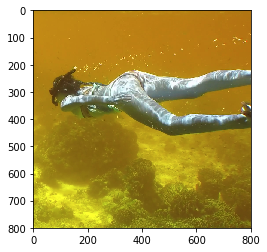

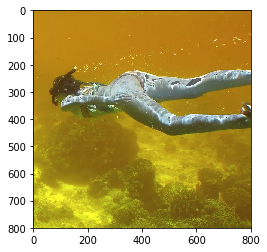

True

In [14]:
#Copying interpolated skin onto the original picture

im_res = np.copy(im_original)

%matplotlib inline
dip.imshow(im_original)
dip.show()

for i in range(np.shape(im_res)[0]):
    for j in range(np.shape(im_res)[1]):
        if (im_skin_interp_def[i,j] > [0, 0, 0]).all():
            im_res[i,j] = im_skin_interp_def[i,j]
            
%matplotlib inline
dip.imshow(im_res)
dip.show()

cv2.imwrite("temp_images/tree_morf/result.png", im_res)